In [10]:
from Simworld import visualize_state,Hex
import numpy as np
import random
from IPython import display
import time

In [5]:
env = Hex(4)

(((1, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0)), 0, False)

((0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (0, 2),
 (1, 2),
 (2, 2),
 (3, 2),
 (0, 3),
 (1, 3),
 (2, 3),
 (3, 3))

Blue player won the game


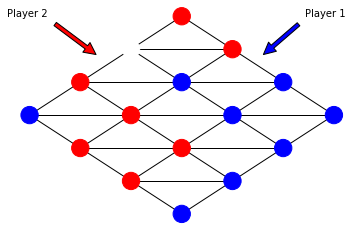

In [4]:
while not is_final:
        frame = visualize_state(env)
        display.clear_output(wait=True)
        display.display(frame)
        time.sleep(1)
        #Add SAP in case there are new states
        
        action = random.sample(action_list,1)[0]
        next_state,reward,is_final = env.step(action)
        state = next_state
display.clear_output(wait=True)
frame = visualize_state(env)
display.display(frame)


Blue player won the game


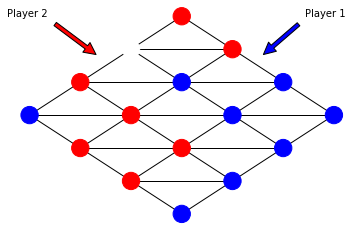

In [5]:
visualize_state(env)

In [6]:
env.board.cells[0][1].state = (1,0)

In [7]:
import copy
env2 = copy.deepcopy(env)

In [8]:
env.board.cells[0][2].state = (1,0)

In [9]:
cell = cells[0][0]
[neig for cell.neighboars.values() if neig.state == self.player]

SyntaxError: cannot assign to function call (<ipython-input-9-e8521bb021ab>, line 2)

In [ ]:
visualize_state(env2)

In [11]:
import random
import numpy as np
from graph import Node
from state import State, NimState
from mcts import *

state = NimState(None, 3, 7, True)
root_node = Node(state)
mtcs = MCTS(NimState)
tree = Tree(root_node)

leaf_node = mtcs.get_leaf_node(tree)

while not leaf_node.state.is_game_over():
    print(f'The node we are expanding is {leaf_node}')
    mtcs.expand_node(leaf_node)
    leaf_node = mtcs.get_leaf_node(tree)

winner = leaf_node.state.get_winner()
print(f'Game over, the winner is player {1 if winner else 2}')

NameError: name 'Tree' is not defined

In [12]:
for episode in 10:
    state = NimState(None, 3, 7, True)
    root_node = Node(state)
    mtcs = MCTS(NimState)
    tree = Tree(root_node)
    

TypeError: 'int' object is not iterable


1. is = save interval for ANET (the actor network) parameters
2. Clear Replay Buffer (RBUF)
3. Randomly initialize parameters (weights and biases) of ANET 
4. For ga in number actual games:

  (a) Initialize the actual game board (Ba) to an empty board.

  (b) sinit ← starting board state

  (c) Initialize the Monte Carlo Tree (MCT) to a single root, which represents sinit 
  
  (d) While Ba not in a final state:

    • Initialize Monte Carlo game board (Bmc) to same state as root. 

    • For gs in number search games:

      – Use tree policy Pt to search from root to a leaf (L) of MCT. Update Bmc with each move.

      – Use ANET to choose rollout actions from L to a final state (F). Update Bmc with each move. 

      – Perform MCTS backpropagation from F to root.

    • next gs

    • D = distribution of visit counts in MCT along all arcs emanating from root. 

    • Add case (root, D) to RBUF

    • Choose actual move (a*) based on D

    • Perform a* on root to produce successor state s*

    • Update Ba to s*

    • In MCT, retain subtree rooted at s*; discard everything else.

    • root←s*

  (e) Train ANET on a random minibatch of cases from RBUF 

  (f) if ga modulo is == 0:

• Save ANET’s current parameters for later use in tournament play. 5. next ga


In [1]:
import random
import numpy as np
from graph import Node
from state import State, NimState
from mcts import *
from ANET import ANET
from Simworld import visualize_state,Hex
from tqdm import tqdm
from IPython import display
import time
import math


In [2]:
#Training parameters
NUMBER_OF_GAMES = 100
GAME = Hex
STARTING_PLAYER_ID = 1
SIZE = 4
NUMBER_SEARCH_GAMES = 100
NUM_AGENTS = 3
BATCH_SIZE = 40

In [3]:
from TOPP import TOPP

In [9]:
top = TOPP("highereps",4, Hex, 1, 200, 5,hidden_layers=(64,32)) #series_name, board_size, game, num_games, episodes, num_agents,#hidden layers
wins = top.run_tournament()


Loaded model from models/highereps_4_ANET_level_0


FileNotFoundError: [Errno 2] No such file or directory: 'models/highereps_4_ANET_level_50'

<AxesSubplot:>

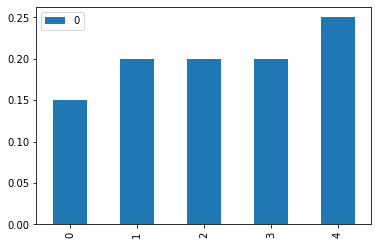

In [8]:
import pandas as pd
df = pd.DataFrame(wins)
norm = df/df[0].sum()
norm.plot.bar()

In [9]:
anet = ANET(input_size=4,hidden_layers=(64,32))
anet.load_anet("simulationsgreat",4,20)

Loaded model from models/simulationsgreat_4_ANET_level_20


In [13]:
test_games = 100000
visualize = False
winner = []

for game in range(test_games):
    #if game==test_games-1:
     #   visualize=True
    
    env = Hex(SIZE,1)
    is_final = env.is_final()
    while not is_final:
            if visualize:
                frame = visualize_state(env)
                display.clear_output(wait=True)
                display.display(frame)
                time.sleep(1)
            action_list = env.legal_actions()
            if env.player==1:
                state = env.get_state()
                _,action_index = anet.get_move(state)
                action = action_space[action_index]
            else:
                action = random.sample(action_list,1)[0]
            next_state,reward,is_final = env.step(action)
            state = next_state
    if visualize:
        display.clear_output(wait=True)
        frame = visualize_state(env)
        display.display(frame)
    winner.append(env.player)



KeyboardInterrupt: 

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(winner)
df.value_counts(normalize=True).plot.bar()



In [47]:
anet.save_anet(SIZE,NUMBER_OF_GAMES)

Model has been saved to models/4_ANET_level_200


In [6]:
board_state = s_init.board
player = s_init.player
state = np.insert(board_state,0,player)


In [21]:
anet2 = ANET(input_size=SIZE,output_size=len(action_space))
anet2.load_anet(SIZE,10)

Loaded model from models/4_ANET_level_10


In [12]:
anet.get_move(state)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x0 and 2x60)

In [16]:
import torch


tensor([1., 9.])

{0: 1, 1: 2, 2: 3, 3: 4}

In [9]:
D = np.zeros(len(action_space))

In [18]:
[1,2,3,4]+[5,7,8,9]

[1, 2, 3, 4, 5, 7, 8, 9]

In [1]:
env.get_action_space()

NameError: name 'env' is not defined

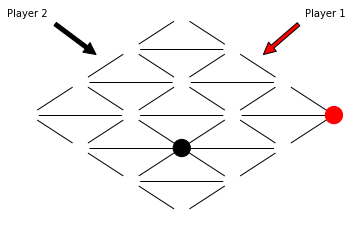

((0, 0, 0, 1), (0, 0, 0, 0), (0, 0, 2, 0), (0, 0, 0, 0))
not legal
(0, 3)


In [20]:
EPSILON = 1
C=1
NUM_SIMULATIONS = 2000
anet = None

environment = Hex(4)
# Initialize environment
environment.reset()
is_final = environment.is_final()
# Initialize mcts
root = Node(environment)
board_mcts = MCTS(EPSILON, anet, C)
is_final = environment.is_final()
action_space = environment.get_action_space()
while not is_final:
    frame = visualize_state(environment)
    display.clear_output(wait=True)
    display.display(frame)
    time.sleep(1)
    print(environment.board.to_tuple())
    if environment.player ==1:
        board_mcts.set_root(root)
        board_mcts.run_simulations(NUM_SIMULATIONS)
        D, new_root = board_mcts.get_probability_distribution(
            board_mcts.root, action_space)
        state = environment.get_state()
        action = action_space[np.argmax(D)]
        if action not in environment.legal_actions():
            print("not legal")
            print(action)
            print(D)
            print(environment.legal_actions)
            break
        # Perform the action in the actual environment
    else:
        action = eval(input("Select move: (row,col)"))
        for child in board_mcts.root.children:
            if child.pred_action==action:
                new_root = child
    root=new_root
    state, _, is_final = environment.step(action)
    
    # Update root of MCST to be the choosen childstate

In [18]:
print(environment.board.to_tuple())

((0, 0, 0, 1), (0, 1, 1, 0), (2, 2, 2, 2), (0, 0, 0, 0))
